# Module: Filter convolution

> Change from narrow-band SED to colors based on Telescope specification

In [ ]:
#| default_exp filter_convolve

In [ ]:
#| hide

from nbdev.showdoc import *

In [ ]:
#| export

import numpy as np
from scipy.interpolate import interp1d as interp1d
from watercolor.ssp_interpolation import spec_ssp_lookup

from watercolor.load_sps_library import load_fsps_spectral_library, load_fsps_age_metallicity
from watercolor.load_sps_library import STELLAR_LIBRARY_DIR

from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data
from watercolor.load_sim_stellar_catalog import GALS_FILE
from watercolor.load_sim_stellar_catalog import Z_SOLAR_PADOVA, H0

from watercolor.calculate_csp import calc_fluxes_for_galaxy

In [ ]:
#| hide

import matplotlib.pylab as plt

In [ ]:
#| hide

gal_tag, stellar_idx, metal_hydro, mass, age_hydro, x, y, z, vx, vy, vz = load_hacc_galaxy_data()


In [ ]:
#| hide

gal_id = 12
unique_gal_tag = np.unique(gal_tag)[gal_id]

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = calc_fluxes_for_galaxy(
    GALS_FILE, 
    unique_gal_tag,
    STELLAR_LIBRARY_DIR)

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


(1.0, 10.0)

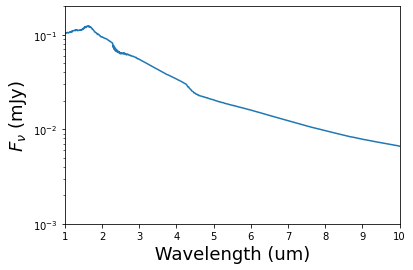

In [ ]:
#| hide

plt.figure()
# plt.plot(spec_wave_ssp/1e4, spec_flux_ssp.T*1e3)
plt.plot(spec_wave_ssp/1e4, spec_csp*1e3)
# plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$F_\nu$ (mJy)', fontsize=18)
plt.xlabel(' Wavelength (um) ', fontsize=18)
plt.ylim(1e-3, 2e-1)
plt.xlim(1, 10)

In [ ]:
#| hide 

import numpy as np
import pandas as pd
import glob
import matplotlib.pylab as plt
import pkg_resources

In [ ]:
#| export

data_str = ['LSST', 'cosmos', 'SPHEREx'][0]
# dataIn = 'filter_specifics/' + data_str + '_only.txt'
FILTER_DIR = '../watercolor/data/filter_specifics/'
# FILTER_NAMES = pkg_resources.resource_stream("watercolor", FILTER_DIR).name

In [ ]:
#| export

def load_filter(dirIn:str=FILTER_DIR # Input directory of the filters 
                              ) -> tuple: #wavelength, transmission co-effecients 
    
    glob.glob()
    spec_flux = np.load(pkg_resources.resource_stream("watercolor", FILTER_DIR + "ssp_spec_flux_lines.npy"))
    spec_wave = np.load(pkg_resources.resource_stream("watercolor", FILTER_DIR + "ssp_spec_wave.npy"))
    print('Library shape: ', spec_flux.shape) 
    print('Wavelength shape: ', spec_wave.shape)
    return spec_flux, spec_wave

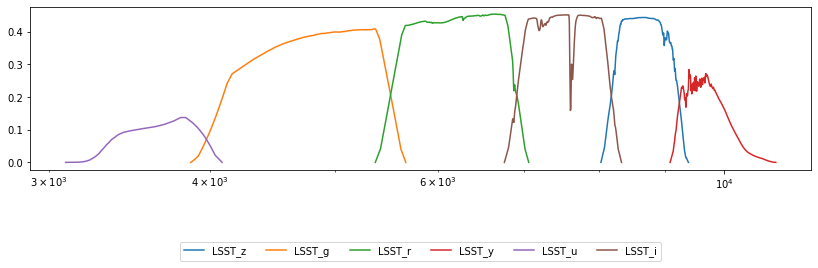

In [ ]:
#| hide

plt.figure(figsize=(14, 3))
for fileIn in glob.glob(FILTER_DIR+data_str+'*.npy'):
    a = np.load(fileIn)
    # print(a.shape)
    plt.plot(a[:, 0], a[:, 1], label=fileIn[36:-4]);

plt.legend(ncol=6, bbox_to_anchor=[0.5, -0.5], loc='center')
plt.xscale('log')

plt.show()

In [ ]:
#| export

def load_indiv_filter_all(filtfile, norm=True):
    
    if ('SPHEREx' in filtfile):
        bandpass_name = filtfile.split('.dat')[0].split('/')[-1]
        x = np.loadtxt(filtfile)
    else:
        bandpass_name = filtfile.split('.npy')[0].split('/')[-1]
        x = np.load(filtfile)
    
    nonz = (x[:,1] != 0.)
    bandpass_wav = x[nonz,0]*1e-4
    bandpass_val = x[nonz,1]

    if norm:
        bandpass_val /= np.sum(bandpass_val)

    cenwav = np.dot(bandpass_wav, bandpass_val)
    # cenwav = np.dot(x[nonz,0], x[nonz,1])

    return bandpass_wav, bandpass_val, cenwav, bandpass_name




In [ ]:
#| export

def clip_bandpass_vals(bandpass_wavs, bandpass_vals):
    all_clip_bandpass_wav, all_clip_bandpass_vals = [], []

    for b in range(len(bandpass_wavs)):
        nonz_bandpass_val = (bandpass_vals[b] > 0)
        clip_bandpass_wav = bandpass_wavs[b][nonz_bandpass_val]
        clip_bandpass_vals = bandpass_vals[b][nonz_bandpass_val]
        all_clip_bandpass_wav.append(clip_bandpass_wav)
        all_clip_bandpass_vals.append(clip_bandpass_vals)

    return all_clip_bandpass_wav, all_clip_bandpass_vals

In [ ]:
#| export 

def load_survey_filters(filtdir='data/spherex_filts/', to_um=True):

    ''' 
    Loads files, returns list of central wavelengths and list of wavelengths/filter responses. 
    Converts wavelengths to microns unless otherwise specified.
    '''
    if ('SPHEREx' in filtdir):
        
        bandpass_wavs, bandpass_vals, central_wavelengths, bandpass_names = [], [], [], []
        bband_idxs = np.arange(1, 7)
    
        for bandidx in bband_idxs:
            # filtfiles = glob.glob(filtdir+'SPHEREx_band'+str(bandidx)+'*.dat')
            filtfiles = glob.glob(filtdir+'*'+str(bandidx)+'*.dat')

            for filtfile in filtfiles:

                bandpass_wav, bandpass_val, cenwav, bandpass_name = load_indiv_filter_all(filtfile)
                bandpass_names.append(bandpass_name)

                bandpass_wavs.append(bandpass_wav)
                bandpass_vals.append(bandpass_val)
                central_wavelengths.append(cenwav)
    
    else:
        bandpass_wavs, bandpass_vals, central_wavelengths, bandpass_names = [], [], [], []
    

        filtfiles = glob.glob(filtdir+'*.npy')
        for filtfile in filtfiles:            

            bandpass_wav, bandpass_val, cenwav, bandpass_name = load_indiv_filter_all(filtfile)
            bandpass_names.append(bandpass_name)

            bandpass_wavs.append(bandpass_wav)
            bandpass_vals.append(bandpass_val)
            central_wavelengths.append(cenwav)
        

    return np.array(central_wavelengths), np.array(bandpass_wavs), np.array(bandpass_vals), np.array(bandpass_names)

In [ ]:
#| export

def sed_to_mock_phot(central_wavelengths, sed_um_wave, sed_mJy_flux, 
                     bandpass_wavs, bandpass_vals, interp_kind='linear', plot=True, clip_bandpass=True):
    # central wavelengths in micron
    if clip_bandpass:
        all_clip_bandpass_wav, all_clip_bandpass_vals = clip_bandpass_vals(bandpass_wavs, bandpass_vals)

    sed_interp = interp1d(sed_um_wave,
                          sed_mJy_flux,
                          kind=interp_kind,
                          bounds_error=False, 
                          fill_value = 0.0)

    band_fluxes = np.zeros_like(central_wavelengths)

    for b, bandpass_wav in enumerate(bandpass_wavs):
        # fluxes in mJy
        if clip_bandpass:
            band_fluxes[b] = np.dot(all_clip_bandpass_vals[b], sed_interp(all_clip_bandpass_wav[b]))
        else:
            band_fluxes[b] = np.dot(bandpass_vals[b], sed_interp(bandpass_wav))

    flux = 1e3*band_fluxes # uJy
    appmag_ext = -2.5*np.log10(flux)+23.9

    if plot:

        wav_um = np.array(central_wavelengths)

        plt.figure(figsize=(12, 4))
        plt.title('sed uJy flux')
        plt.plot(sed_um_wave, 1e3*sed_mJy_flux, color='k', zorder=5, alpha=0.5)
        plt.scatter(wav_um, flux, color='r', label='bandpass-convolved fluxes', s=30)
        # plt.ylim(0, 1.2*np.max(flux))
        plt.xlabel('um', fontsize=16)
        plt.ylabel('uJy', fontsize=16)
        plt.xlim(wav_um.min()*0.8, wav_um.max()*1.2)
        plt.tick_params(labelsize=14)
        plt.legend()
        plt.show()

    return flux, appmag_ext, band_fluxes

In [ ]:
#| hide

filters_dir = FILTER_DIR+data_str
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_filters(filtdir=filters_dir, to_um=True)

/tmp/ipykernel_1383287/3355700171.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(central_wavelengths), np.array(bandpass_wavs), np.array(bandpass_vals), np.array(bandpass_names)


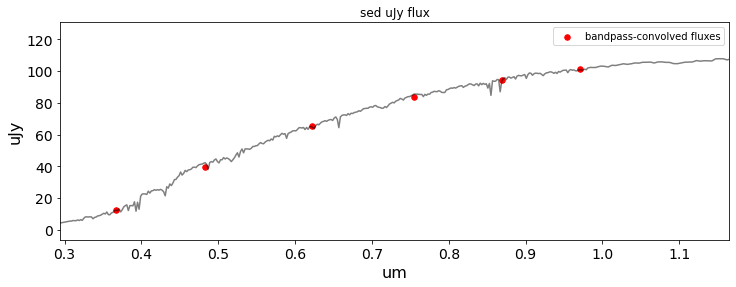

In [ ]:
#| hide

sed_um_wave = spec_wave_ssp/1e4
sed_mJy_flux = spec_csp*1e3

flux_survey, appmag_ext_survey_satellite, band_fluxes_survey = sed_to_mock_phot(central_wavelengths, 
                                                                          sed_um_wave, 
                                                                          sed_mJy_flux, 
                                                                          bandpass_wavs, 
                                                                          bandpass_vals, 
                                                                          interp_kind='linear',
                                                                          plot=True,
                                                                          clip_bandpass=True)

survey_mags = appmag_ext_survey_satellite

In [ ]:
'''

#| hide

from cycler import cycler
from matplotlib.cm import get_cmap


f, a = plt.subplots(1, figsize=(14, 2))
name = "viridis"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
# a.set_prop_cycle(color=colors)

for central_idx in range(central_wavelengths.shape[0]):
    # a.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']))
    a.plot(bandpass_wavs[central_idx], bandpass_vals[central_idx])
    
# a.set_xlim(bandpass_wavs[0].min(), bandpass_wavs[-1].max())

'''

'\n\n#| hide\n\nfrom cycler import cycler\nfrom matplotlib.cm import get_cmap\n\n\nf, a = plt.subplots(1, figsize=(14, 2))\nname = "viridis"\ncmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap\ncolors = cmap.colors  # type: list\n# a.set_prop_cycle(color=colors)\n\nfor central_idx in range(central_wavelengths.shape[0]):\n    # a.set_prop_cycle(cycler(\'color\', [\'c\', \'m\', \'y\', \'k\']))\n    a.plot(bandpass_wavs[central_idx], bandpass_vals[central_idx])\n    \n# a.set_xlim(bandpass_wavs[0].min(), bandpass_wavs[-1].max())\n\n'

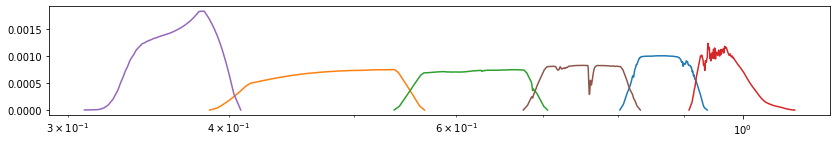

In [ ]:
#| hide

from cycler import cycler
from matplotlib.cm import get_cmap


f, a = plt.subplots(1, figsize=(14, 2))
name = "viridis"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
# a.set_prop_cycle(color=colors)

for central_idx in range(central_wavelengths.shape[0]):
    # a.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']))
    a.plot(bandpass_wavs[central_idx], bandpass_vals[central_idx])
   
a.set_xscale('log')
# a.set_xlim(0, 5)

In [ ]:
#| hide

import nbdev; nbdev.nbdev_export()